In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('CountryComp_clean_alpha3.csv')
df = df.drop(['Unnamed: 0', '2035 (GWh)', '2040 (GWh)', '2050 (GWh)'], axis=1)
# df

In [3]:
# One-hot encode the categorical columns 'Manufacturer' and 'Country'
df_encoded = pd.get_dummies(df, columns=['Manufacturer', 'Country', 'alpha3_code'], drop_first=True)

# Display the DataFrame with encoded features
print(df_encoded.head())


   2022 (GWh)  2023 (GWh)  2024 (GWh)  2025 (GWh)  2028 (GWh)  2030 (GWh)  \
0       184.4       259.7         NaN         NaN       307.0       600.0   
1         0.0         0.0         0.0         NaN         NaN       100.0   
2         NaN         NaN         NaN       260.0         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN        65.0         NaN         NaN        65.0   

   Manufacturer_BYD  Manufacturer_Basquevolt  Manufacturer_Beyonder  \
0             False                    False                  False   
1             False                    False                  False   
2             False                    False                  False   
3             False                    False                  False   
4             False                    False                  False   

   Manufacturer_Blackstone Resources  ...  alpha3_code_GBR  alpha3_code_HUN  \
0                              

In [4]:
def prepare_data(year):
    features = df_encoded.drop(columns=[f'{year} (GWh)'])
    target = df_encoded[f'{year} (GWh)']
    
    # Remove rows where the target is NaN
    mask = target.notna()
    return features[mask], target[mask]

In [5]:
years = [2022, 2023, 2024, 2025, 2028, 2030]

In [6]:
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor()
}

In [7]:
results = {}

In [8]:
for year in years:
    X, y = prepare_data(year)
    
    # Check if there's enough data to split
    if len(y) < 2:
        print(f"Not enough data to split for year {year}. Skipping...")
        continue
    
    # Impute missing values in features
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

    year_results = {}
    
    for name, model in models.items():
        try:
            # Cross-validation
            kfold = KFold(n_splits=2, shuffle=True, random_state=42)
            cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
            
            # Train the model on the full training set
            model.fit(X_train, y_train)
            
            # Test the model on the test set
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            
            # Store the results
            year_results[name] = {
                "CV Mean MSE": -cv_results.mean(),
                "Test MSE": mse
            }
            
            print(f"Year: {year}, Model: {name}, Test MSE: {mse:.4f}")
        except ValueError as e:
            print(f"Error for year {year} with model {name}: {e}")
    
    if year_results:
        results[year] = year_results


Year: 2022, Model: LinearRegression, Test MSE: 1563.2677
Year: 2022, Model: DecisionTree, Test MSE: 12973.2100


c:\Users\veren\anaconda3\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: ['2025 (GWh)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Year: 2022, Model: RandomForest, Test MSE: 21206.6406
Year: 2023, Model: LinearRegression, Test MSE: 465436.6692
Year: 2023, Model: DecisionTree, Test MSE: 11149.5700


c:\Users\veren\anaconda3\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: ['2025 (GWh)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Year: 2023, Model: RandomForest, Test MSE: 23049.7446
Year: 2024, Model: LinearRegression, Test MSE: 72.8662
Year: 2024, Model: DecisionTree, Test MSE: 7.8120
Year: 2024, Model: RandomForest, Test MSE: 8.0727
Year: 2025, Model: LinearRegression, Test MSE: 18641.8806
Year: 2025, Model: DecisionTree, Test MSE: 20316.0000


c:\Users\veren\anaconda3\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: ['2022 (GWh)' '2023 (GWh)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Year: 2025, Model: RandomForest, Test MSE: 20784.7973
Year: 2028, Model: LinearRegression, Test MSE: 11237.8831
Year: 2028, Model: DecisionTree, Test MSE: 3130.0000
Year: 2028, Model: RandomForest, Test MSE: 159.0840
Year: 2030, Model: LinearRegression, Test MSE: 2656463.7323
Year: 2030, Model: DecisionTree, Test MSE: 63198.8000
Year: 2030, Model: RandomForest, Test MSE: 65701.5732


In [9]:
for year in results:
    print(f"Year: {year}")
    for model in results[year]:
        print(f"  Model: {model}, CV Mean MSE: {results[year][model]['CV Mean MSE']:.4f}, Test MSE: {results[year][model]['Test MSE']:.4f}")


Year: 2022
  Model: LinearRegression, CV Mean MSE: 4970.2500, Test MSE: 1563.2677
  Model: DecisionTree, CV Mean MSE: 4970.2500, Test MSE: 12973.2100
  Model: RandomForest, CV Mean MSE: 4970.2500, Test MSE: 21206.6406
Year: 2023
  Model: LinearRegression, CV Mean MSE: 10418.1802, Test MSE: 465436.6692
  Model: DecisionTree, CV Mean MSE: 3153.8650, Test MSE: 11149.5700
  Model: RandomForest, CV Mean MSE: 4838.8693, Test MSE: 23049.7446
Year: 2024
  Model: LinearRegression, CV Mean MSE: 382.3562, Test MSE: 72.8662
  Model: DecisionTree, CV Mean MSE: 376.0561, Test MSE: 7.8120
  Model: RandomForest, CV Mean MSE: 350.9486, Test MSE: 8.0727
Year: 2025
  Model: LinearRegression, CV Mean MSE: 2195.7886, Test MSE: 18641.8806
  Model: DecisionTree, CV Mean MSE: 1324.6000, Test MSE: 20316.0000
  Model: RandomForest, CV Mean MSE: 926.2589, Test MSE: 20784.7973
Year: 2028
  Model: LinearRegression, CV Mean MSE: 609418.5418, Test MSE: 11237.8831
  Model: DecisionTree, CV Mean MSE: 13121.2083, Test 

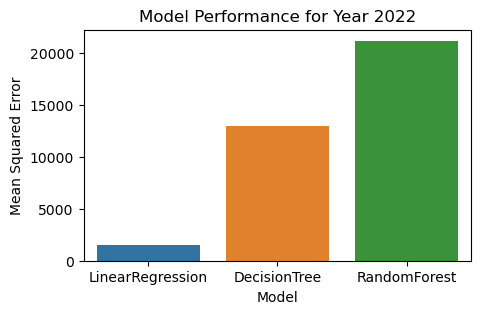

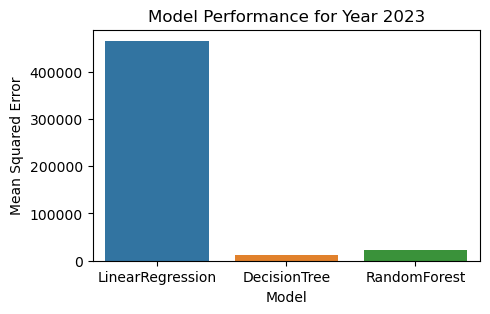

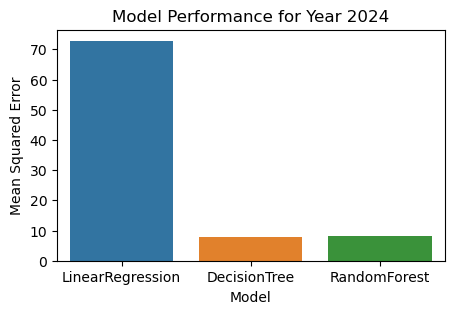

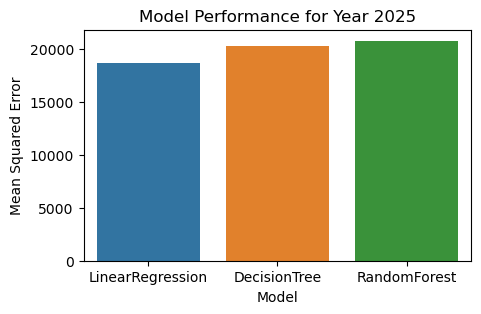

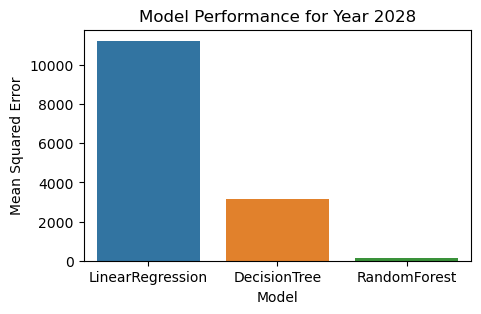

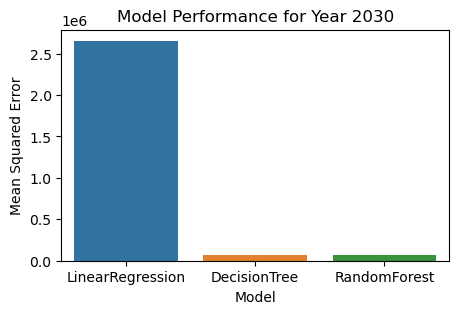

In [10]:
for year in results:
    year_results = results[year]
    plt.figure(figsize=(5, 3))
    sns.barplot(x=list(year_results.keys()), y=[year_results[model]['Test MSE'] for model in year_results])
    plt.title(f'Model Performance for Year {year}')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Model')
    plt.show()

In [11]:
def fill_missing_values(year, best_model):
    X, y = prepare_data(year)
    missing_mask = df_encoded[f'{year} (GWh)'].isna()
    
    if missing_mask.any():
        # Impute missing values in features
        imputer = SimpleImputer(strategy='mean')
        X_imputed = imputer.fit_transform(X)
        
        # Train the best model on the entire data (with known values)
        best_model.fit(X_imputed, y)
        
        # Impute the missing features and predict the missing values
        missing_features = df_encoded[missing_mask].drop(columns=[f'{year} (GWh)'])
        missing_features_imputed = imputer.transform(missing_features)
        predictions = best_model.predict(missing_features_imputed)
        
        # Update the DataFrame with the predictions
        df_encoded.loc[missing_mask, f'{year} (GWh)'] = predictions

In [12]:
best_models = {
    2022: LinearRegression(),
    2023: RandomForestRegressor(),
    2024: DecisionTreeRegressor(),
    2025: LinearRegression(),
    2028: RandomForestRegressor(),
    2030: RandomForestRegressor()
}

In [13]:
for year in best_models:
    fill_missing_values(year, best_models[year])

c:\Users\veren\anaconda3\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: ['2025 (GWh)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\Users\veren\anaconda3\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: ['2025 (GWh)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\Users\veren\anaconda3\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: ['2025 (GWh)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\Users\veren\anaconda3\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: ['2025 (GWh)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [14]:
# df_encoded

## Analyze and Validate the Predictions

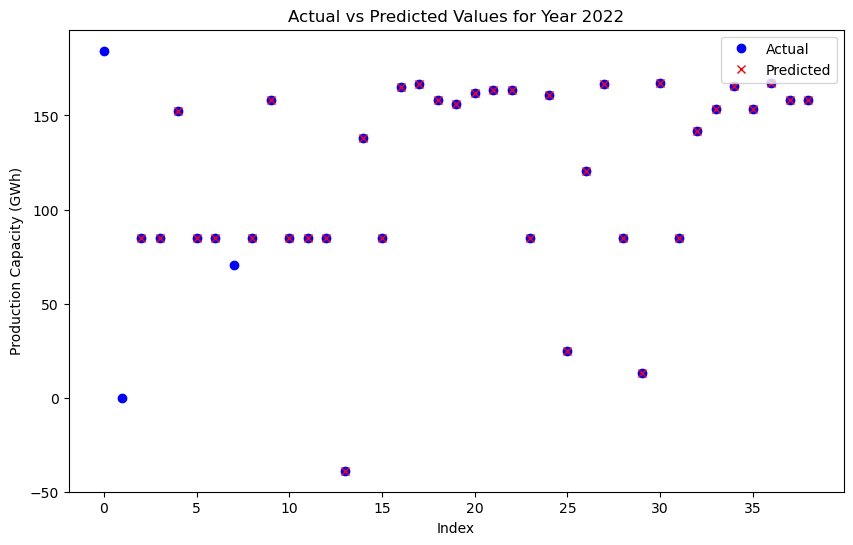

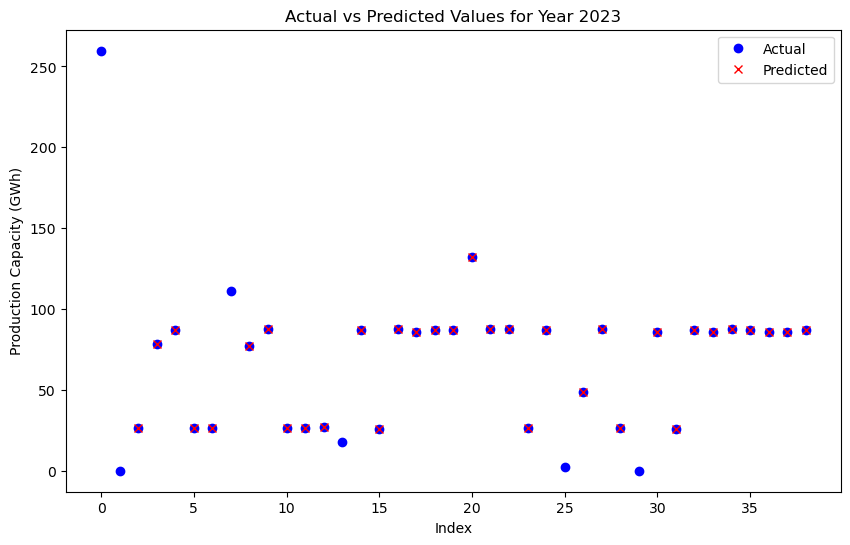

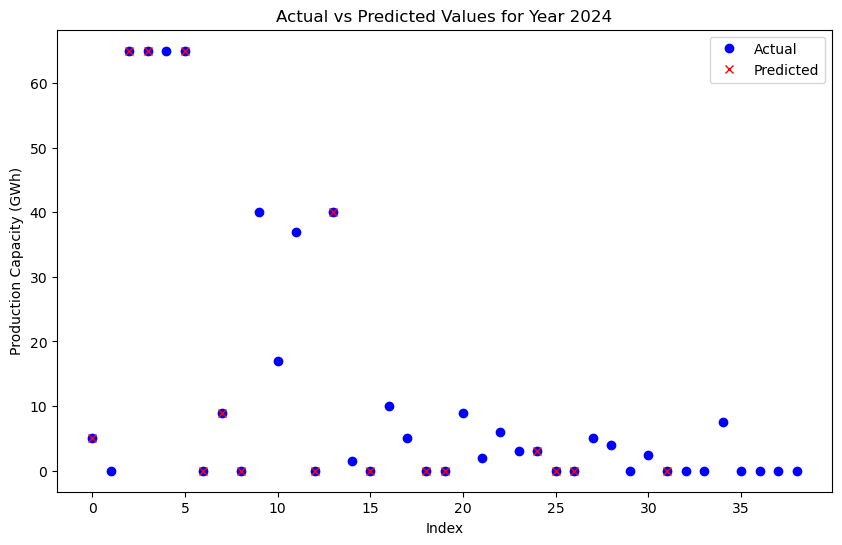

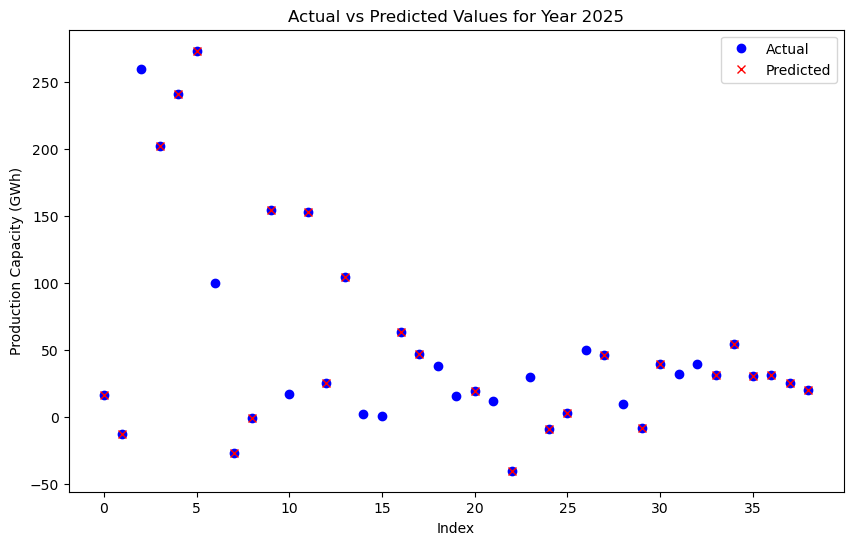

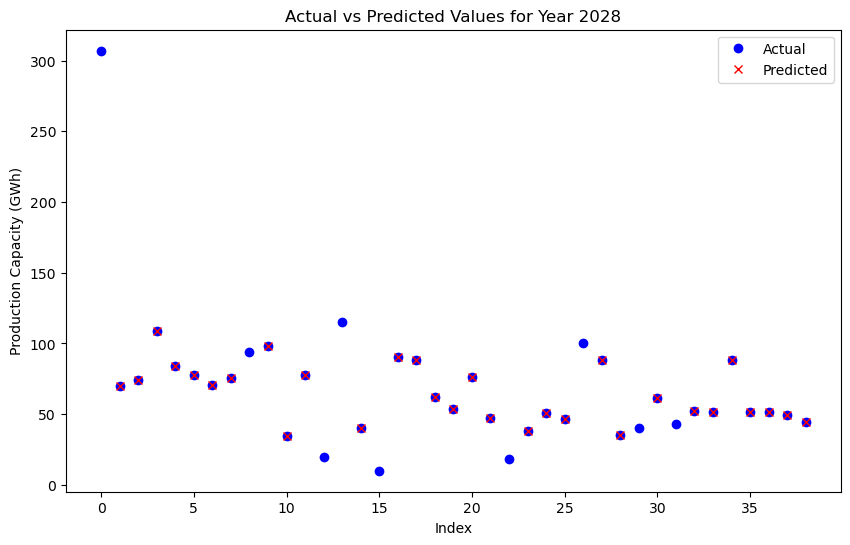

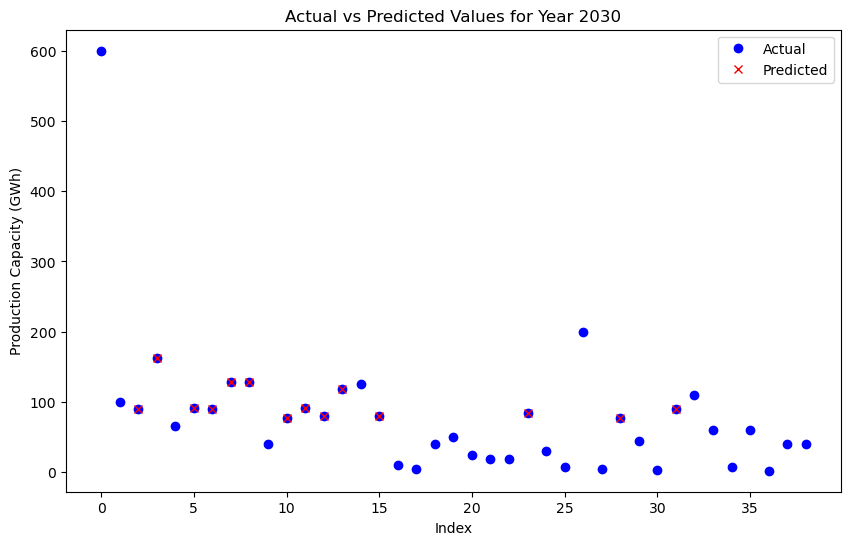

In [15]:
# Function to plot actual vs predicted values
def plot_actual_vs_predicted(year):
    actual = df_encoded[f'{year} (GWh)'].dropna()
    predicted_mask = df[f'{year} (GWh)'].isna()
    predicted = df_encoded.loc[predicted_mask, f'{year} (GWh)']

    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual.values, 'o', label='Actual', color='blue')
    plt.plot(predicted.index, predicted.values, 'x', label='Predicted', color='red')
    plt.title(f'Actual vs Predicted Values for Year {year}')
    plt.xlabel('Index')
    plt.ylabel('Production Capacity (GWh)')
    plt.legend()
    plt.show()

# Plot actual vs predicted for each year we filled
for year in best_models:
    if df[f'{year} (GWh)'].isna().any():
        plot_actual_vs_predicted(year)


In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Re-train and fill missing values using IterativeImputer
def fill_missing_values_advanced(year, best_model):
    X, y = prepare_data(year)
    missing_mask = df_encoded[f'{year} (GWh)'].isna()
    
    if missing_mask.any():
        # Use IterativeImputer to handle missing values in features
        imputer = IterativeImputer(random_state=42)
        X_imputed = imputer.fit_transform(X)
        
        # Train the best model on the entire data (with known values)
        best_model.fit(X_imputed, y)
        
        # Impute the missing features and predict the missing values
        missing_features = df_encoded[missing_mask].drop(columns=[f'{year} (GWh)'])
        missing_features_imputed = imputer.transform(missing_features)
        predictions = best_model.predict(missing_features_imputed)
        
        # Update the DataFrame with the predictions
        df_encoded.loc[missing_mask, f'{year} (GWh)'] = predictions

# Fill missing values for each year with the best model using advanced imputation
for year in best_models:
    fill_missing_values_advanced(year, best_models[year])

# Display the updated DataFrame
print(df_encoded.head())


   2022 (GWh)  2023 (GWh)  2024 (GWh)  2025 (GWh)  2028 (GWh)  2030 (GWh)  \
0  184.400000     259.700         5.0   16.250875      307.00     600.000   
1    0.000000       0.000         0.0  -12.795655       70.12     100.000   
2   84.943387      26.619        65.0  260.000000       74.36      89.616   
3   84.907995      78.175        65.0  202.339075      108.48     161.936   
4  152.332834      87.090        65.0  241.136953       84.16      65.000   

   Manufacturer_BYD  Manufacturer_Basquevolt  Manufacturer_Beyonder  \
0             False                    False                  False   
1             False                    False                  False   
2             False                    False                  False   
3             False                    False                  False   
4             False                    False                  False   

   Manufacturer_Blackstone Resources  ...  alpha3_code_GBR  alpha3_code_HUN  \
0                              

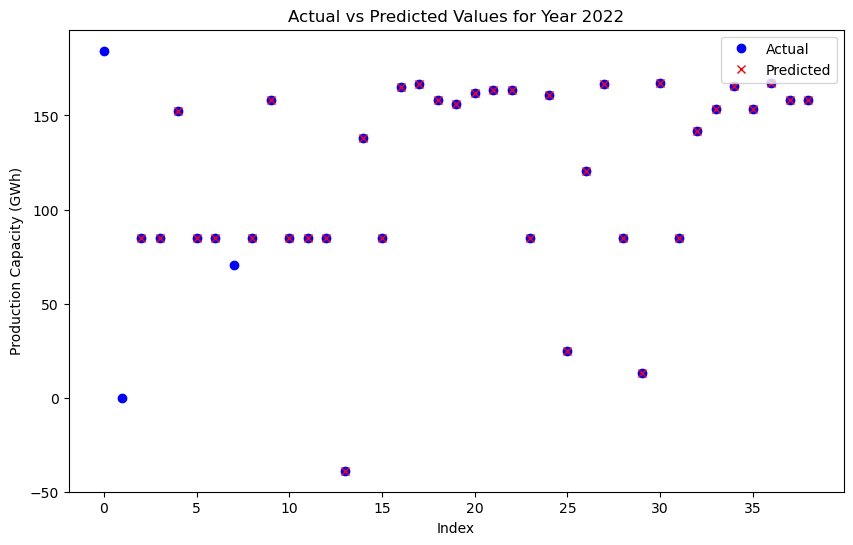

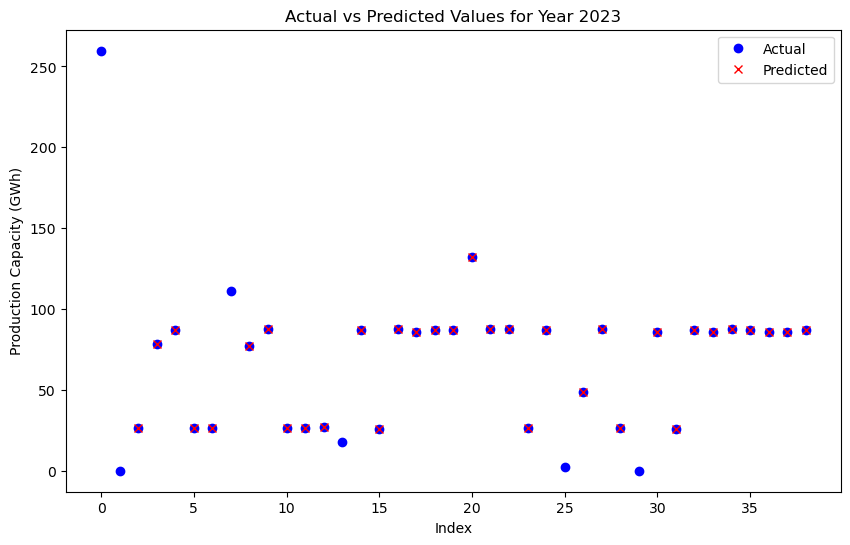

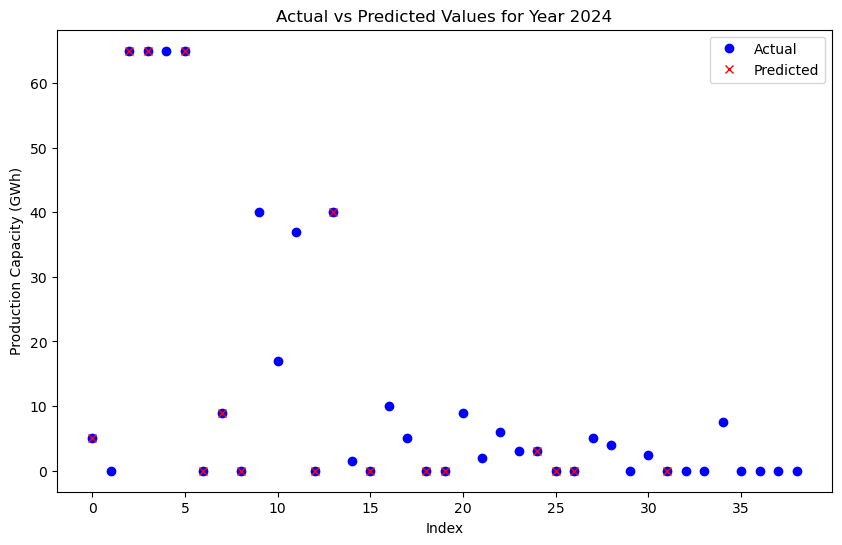

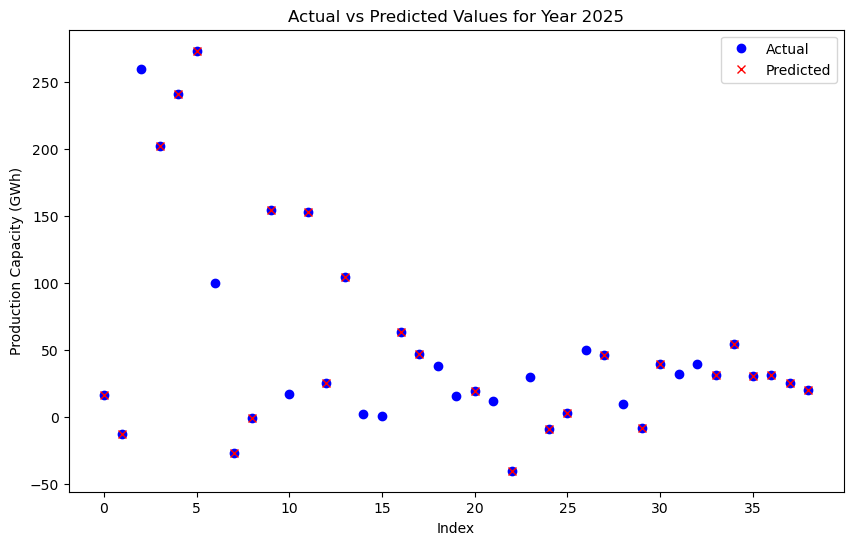

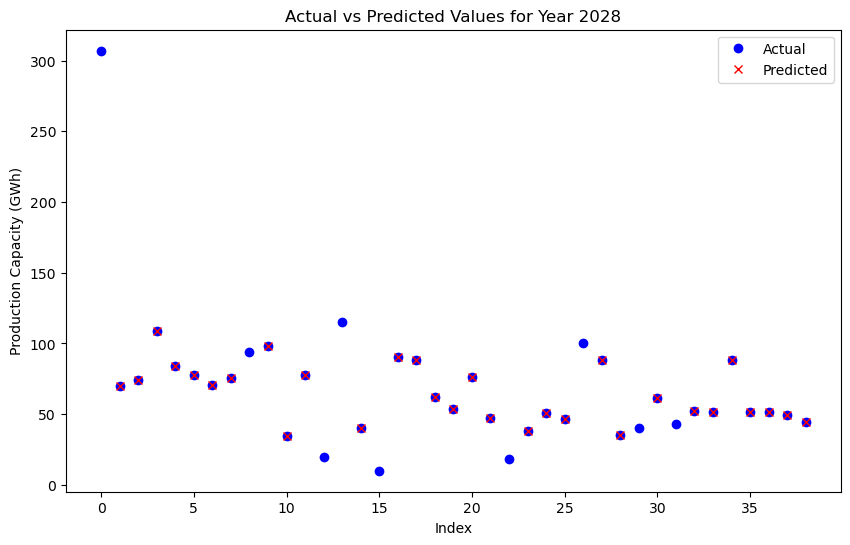

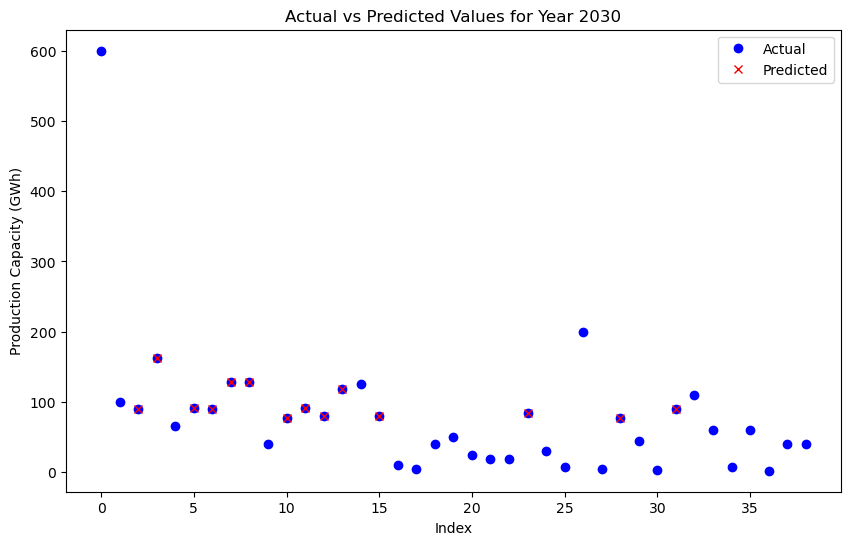

In [17]:
for year in best_models:
    if df[f'{year} (GWh)'].isna().any():
        plot_actual_vs_predicted(year)

In [18]:
df_comb = df.copy()
print(df_comb.head())

  Manufacturer            Country  2022 (GWh)  2023 (GWh)  2024 (GWh)  \
0         CATL              China       184.4       259.7         NaN   
1         CATL            Germany         0.0         0.0         0.0   
2      LG Chem  Republic of Korea         NaN         NaN         NaN   
3      LG Chem              China         NaN         NaN         NaN   
4      LG Chem             Poland         NaN         NaN        65.0   

   2025 (GWh)  2028 (GWh)  2030 (GWh) alpha3_code  
0         NaN       307.0       600.0         CHN  
1         NaN         NaN       100.0         DEU  
2       260.0         NaN         NaN         ROK  
3         NaN         NaN         NaN         CHN  
4         NaN         NaN        65.0         POL  


In [19]:
alpha3_codes = list(set(df['alpha3_code']))
#alpha3_codes

In [20]:
manuf = list(set(df['Manufacturer']))
#manuf

In [21]:
cols = ['2022 (GWh)', '2023 (GWh)', '2024 (GWh)', '2025 (GWh)', '2028 (GWh)', '2030 (GWh)']

In [45]:
df_clean = df_encoded.copy()
df_clean['Manufacturer'] = None
df_clean['alpha3'] = None
#df_clean

In [46]:
manufacturer_map = {
    'Manufacturer_Northvolt': 'Northvolt',
    'Manufacturer_Samsung SDI': 'Samsung SDI',
    'Manufacturer_Laclanche': 'Laclanche',
    'Manufacturer_UK Centre of Electrification': 'UK Centre of Electrification',
    'Manufacturer_Varta': 'Varta',
    # 'Manufacturer_ACC': 'ACC',
    'Manufacturer_Basquevolt': 'Basquevolt',
    'Manufacturer_Blyth': 'Blyth',
    'Manufacturer_Inobat': 'Inobat',
    'Manufacturer_LG Chem': 'LG Chem',
    'Manufacturer_Morrow': 'Morrow',
    'Manufacturer_Itavolt': 'Itavolt',
    'Manufacturer_Freyr': 'Freyr',
    'Manufacturer_CATL': 'CATL',
    'Manufacturer_SCB': 'SCB',
    'Manufacturer_Beyonder': 'Beyonder',
    'Manufacturer_Volkswagen': 'Volkswagen',
    'Manufacturer_Panasonic': 'Panasonic',
    'Manufacturer_Envision AESC': 'Envision AESC',
    'Manufacturer_TESLA': 'TESLA',
    'Manufacturer_Dunkirk': 'Dunkirk',
    'Manufacturer_SK On': 'SK On',
    'Manufacturer_FAAM': 'FAAM',
    'Manufacturer_Impact': 'Impact',
    'Manufacturer_Envision': 'Envision',
    'Manufacturer_BYD': 'BYD',
    'Manufacturer_Blackstone Resources': 'Blackstone Resources'
}

alpha3_map = {
    'alpha3_code_CHN': 'CHN',
    'alpha3_code_SWE': 'SWE',
    'alpha3_code_POL': 'POL',
    'alpha3_code_GBR': 'GBR',
    'alpha3_code_ROK': 'ROK',
    'alpha3_code_ESP': 'ESP',
    'alpha3_code_HUN': 'HUN',
    'alpha3_code_FRA': 'FRA',
    'alpha3_code_NOR': 'NOR',
    'alpha3_code_DEU': 'DEU',
    'alpha3_code_JPN': 'JPN',
    'alpha3_code_ITA': 'ITA',
    'alpha3_code_SVK': 'SVK',
    'alpha3_code_USA': 'USA',
    #'alpha3_code_CHE': 'CHE'
}

# Function to apply
def fill_manufacturer(row):
    for col, manufacturer in manufacturer_map.items():
        if row[col]:
            return manufacturer
    return None

def fill_alpha3(row):
    for col, alpha3_code in alpha3_map.items():
        if row[col]:
            return alpha3_code
    return None

# Applying the functions to create the new columns
df_clean['Manufacturer'] = df_clean.apply(fill_manufacturer, axis=1)
df_clean['alpha3'] = df_clean.apply(fill_alpha3, axis=1)

# Display the DataFrame with the new columns filled
# print(df_clean.head())

In [47]:
df_clean = df_clean.drop(['Manufacturer_Northvolt', 'Manufacturer_Samsung SDI',
    'Manufacturer_Laclanche',
    'Manufacturer_UK Centre of Electrification',
    'Manufacturer_Varta',
    'Manufacturer_Basquevolt',
    'Manufacturer_Blyth',
    'Manufacturer_Inobat',
    'Manufacturer_LG Chem',
    'Manufacturer_Morrow',
    'Manufacturer_Itavolt',
    'Manufacturer_Freyr',
    'Manufacturer_CATL',
    'Manufacturer_SCB',
    'Manufacturer_Beyonder',
    'Manufacturer_Volkswagen',
    'Manufacturer_Panasonic',
    'Manufacturer_Envision AESC',
    'Manufacturer_TESLA',
    'Manufacturer_Dunkirk',
    'Manufacturer_SK On',
    'Manufacturer_FAAM',
    'Manufacturer_Impact',
    'Manufacturer_Envision',
    'Manufacturer_BYD',
    'Manufacturer_Blackstone Resources',
    'alpha3_code_CHN',
    'alpha3_code_SWE',
    'alpha3_code_POL',
    'alpha3_code_GBR',
    'alpha3_code_ROK',
    'alpha3_code_ESP',
    'alpha3_code_HUN',
    'alpha3_code_FRA',
    'alpha3_code_NOR',
    'alpha3_code_DEU',
    'alpha3_code_JPN',
    'alpha3_code_ITA',
    'alpha3_code_SVK',
    'alpha3_code_USA',
    'Country_France', 'Country_Germany', 'Country_Italy', 'Country_Poland', 'Country_Hungary',
    'Country_Sweden', 'Country_Norway', 'Country_United States of America', 'Country_Japan',
    'Country_Republic of Korea', 'Country_Slovakia', 'Country_Spain', 'Country_Switzerland', 'Country_United Kingdom'
    ], axis=1)
df_clean

,2022 (GWh),2023 (GWh),2024 (GWh),2025 (GWh),2028 (GWh),2030 (GWh),Manufacturer,alpha3
0,184.400000,259.700,5.0,16.250875,307.00,600.000,CATL,CHN
1,0.000000,0.000,0.0,-12.795655,70.12,100.000,CATL,DEU
2,84.943387,26.619,65.0,260.000000,74.36,89.616,LG Chem,ROK
3,84.907995,78.175,65.0,202.339075,108.48,161.936,LG Chem,CHN
4,152.332834,87.090,65.0,241.136953,84.16,65.000,LG Chem,POL
5,84.943387,26.619,65.0,273.633812,77.43,90.966,LG Chem,USA
6,84.943387,26.619,0.0,100.000000,70.42,90.040,TESLA,USA
7,70.500000,111.400,9.0,-26.609192,75.68,128.200,BYD,CHN
8,84.907995,77.211,0.0,-0.648611,94.00,128.170,Samsung SDI,CHN
9,158.244189,87.701,40.0,155.012855,98.35,40.000,Samsung SDI,HUN


In [48]:
numeric_cols = df_clean.select_dtypes(include=['int', 'float']).columns

df_clean[numeric_cols] = df_clean[numeric_cols].applymap(lambda x: 0 if x < 0 else x)

In [49]:
df_clean

,2022 (GWh),2023 (GWh),2024 (GWh),2025 (GWh),2028 (GWh),2030 (GWh),Manufacturer,alpha3
0,184.400000,259.700,5.0,16.250875,307.00,600.000,CATL,CHN
1,0.000000,0.000,0.0,0.000000,70.12,100.000,CATL,DEU
2,84.943387,26.619,65.0,260.000000,74.36,89.616,LG Chem,ROK
3,84.907995,78.175,65.0,202.339075,108.48,161.936,LG Chem,CHN
4,152.332834,87.090,65.0,241.136953,84.16,65.000,LG Chem,POL
5,84.943387,26.619,65.0,273.633812,77.43,90.966,LG Chem,USA
6,84.943387,26.619,0.0,100.000000,70.42,90.040,TESLA,USA
7,70.500000,111.400,9.0,0.000000,75.68,128.200,BYD,CHN
8,84.907995,77.211,0.0,0.000000,94.00,128.170,Samsung SDI,CHN
9,158.244189,87.701,40.0,155.012855,98.35,40.000,Samsung SDI,HUN


In [26]:
df_clean.to_csv('PredictedCapacity.csv')

In [50]:
#numeric_cols = df_clean.select_dtypes(include=['int', 'float']).columns

df_clean[numeric_cols] = df_clean[numeric_cols].applymap(lambda x: '' if x == 0 else x)

In [51]:
df_clean

,2022 (GWh),2023 (GWh),2024 (GWh),2025 (GWh),2028 (GWh),2030 (GWh),Manufacturer,alpha3
0,184.4,259.7,5.0,16.250875,307.00,600.000,CATL,CHN
1,,,,,70.12,100.000,CATL,DEU
2,84.943387,26.619,65.0,260.0,74.36,89.616,LG Chem,ROK
3,84.907995,78.175,65.0,202.339075,108.48,161.936,LG Chem,CHN
4,152.332834,87.09,65.0,241.136953,84.16,65.000,LG Chem,POL
5,84.943387,26.619,65.0,273.633812,77.43,90.966,LG Chem,USA
6,84.943387,26.619,,100.0,70.42,90.040,TESLA,USA
7,70.5,111.4,9.0,,75.68,128.200,BYD,CHN
8,84.907995,77.211,,,94.00,128.170,Samsung SDI,CHN
9,158.244189,87.701,40.0,155.012855,98.35,40.000,Samsung SDI,HUN


In [59]:
df_clean.to_excel('PredictedCapacity.xlsx')

In [55]:
import pycountry

In [57]:
# Function to map alpha-3 codes to country names
def get_country_name_from_alpha3(alpha3_code):
    # Check if the alpha3_code is valid and a string
    if isinstance(alpha3_code, str):
        # Normalize the code to uppercase
        alpha3_code = alpha3_code.upper()
        try:
            country = pycountry.countries.get(alpha_3=alpha3_code)
            return country.name if country else 'Unknown'
        except LookupError:
            return 'Unknown'
    else:
        return 'Unknown'

# Apply the function to the 'alpha3' column
df_clean['Country'] = df_clean['alpha3'].apply(get_country_name_from_alpha3)

In [58]:
df_clean

,2022 (GWh),2023 (GWh),2024 (GWh),2025 (GWh),2028 (GWh),2030 (GWh),Manufacturer,alpha3,Country
0,184.4,259.7,5.0,16.250875,307.00,600.000,CATL,CHN,China
1,,,,,70.12,100.000,CATL,DEU,Germany
2,84.943387,26.619,65.0,260.0,74.36,89.616,LG Chem,ROK,Unknown
3,84.907995,78.175,65.0,202.339075,108.48,161.936,LG Chem,CHN,China
4,152.332834,87.09,65.0,241.136953,84.16,65.000,LG Chem,POL,Poland
5,84.943387,26.619,65.0,273.633812,77.43,90.966,LG Chem,USA,United States
6,84.943387,26.619,,100.0,70.42,90.040,TESLA,USA,United States
7,70.5,111.4,9.0,,75.68,128.200,BYD,CHN,China
8,84.907995,77.211,,,94.00,128.170,Samsung SDI,CHN,China
9,158.244189,87.701,40.0,155.012855,98.35,40.000,Samsung SDI,HUN,Hungary
